In [29]:
import argparse
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import xbpch
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics import ProgressBar
from matplotlib import colorbar, colors


In [4]:

OLD = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.bpch'
NEW = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.new.bpch'

In [5]:
OLD_ds = xbpch.open_bpchdataset(OLD)
NEW_ds = xbpch.open_bpchdataset(NEW)

/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [6]:
#Unit conversion from IDL code
#ngm3_ppqv = 112.
#   pptv_ngm3 = 8.93d0 ;eds 5/10/11



#if keyword_set(ppq) then begin
#      ; convert pptv -> ppqv
#      Data_mean = Data_mean * 1e3
 #  endif else begin
  #    ; convert pptv -> ng/m3
   #   Data_mean = Data_mean * pptv_ngm3 ;eds 5/10/11
    
    
print (NEW_ds)

<xarray.Dataset>
Dimensions:            (lat: 91, lev: 47, lev_edge: 48, lon: 144, nv: 2, time: 12)
Coordinates:
  * lev                (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 ...
  * lon                (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 ...
  * lat                (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 ...
  * time               (time) datetime64[ns] 2013-01-01 2013-02-01 ...
  * nv                 (nv) int64 0 1
Dimensions without coordinates: lev_edge
Data variables:
    HG_SRCE_Hg0_an     (time, lon, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    time_bnds          (time, nv) datetime64[ns] 2013-01-01 2013-02-01 ...
    HG_SRCE_Hg0_aq     (time, lon, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HG_SRCE_Hg0_oc     (time, lon, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HG_SRCE_Hg0_ln     (time, lon, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HG_SRCE_Hg0_na     (time, lon, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HG_SRCE_Hg2_an     (t

In [7]:
# Setting variables for the old model dataset
# Reading in the data file for Hg0, making a mean of all values in respect to time and converting to ng/m^3
OLD_Hg0=((OLD_ds['IJ_AVG_S_Hg0'].isel(lev=0).mean('time')) * 8.93)              #*1e3)

                             
OLD_Hg2=((OLD_ds['IJ_AVG_S_Hg2'].isel(lev=0).mean('time'))  * 8.93)                 #   *1e3)
TGM_Old = (OLD_Hg0 + OLD_Hg2)



# Setting variables for the new model data set
NEW_Hg0=((NEW_ds['IJ_AVG_S_Hg0'].isel(lev=0).mean('time'))*8.93)

                             
NEW_Hg2=((NEW_ds['IJ_AVG_S_Hg2'].isel(lev=0).mean('time'))*8.93)

TGM_New = NEW_Hg0 + NEW_Hg2

print (OLD_Hg2)
#print (NEW_Hg0)
print (TGM_Old)

<xarray.DataArray 'IJ_AVG_S_Hg2' (lon: 144, lat: 91)>
dask.array<mul, shape=(144, 91), dtype=float32, chunksize=(144, 91)>
Coordinates:
    lev      float64 0.9925
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
<xarray.DataArray (lon: 144, lat: 91)>
dask.array<add, shape=(144, 91), dtype=float32, chunksize=(144, 91)>
Coordinates:
    lev      float64 0.9925
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...


In [8]:
Abs_diff = TGM_New - TGM_Old
Perc_diff = (Abs_diff / TGM_Old)*100
print (Abs_diff)

<xarray.DataArray (lon: 144, lat: 91)>
dask.array<sub, shape=(144, 91), dtype=float32, chunksize=(144, 91)>
Coordinates:
    lev      float64 0.9925
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...


/home/brittany/anaconda3/envs/geoschem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


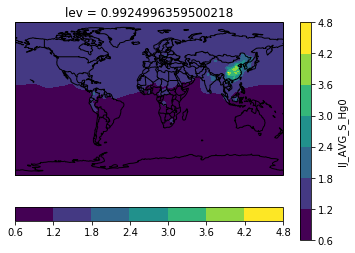

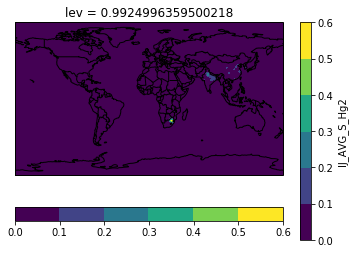

In [9]:

fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


da = (OLD_Hg0)#*1e3)


im = da.plot.contourf(x='lon', y='lat')#, da.values.T)#transform=ccrs.PlateCarree()
#im = ax.contourf(da.lon.values, da.lat.values, da.values.T)
cb = fig.colorbar(im, ax=ax, orientation='horizontal')

ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS)





fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


da_2= (OLD_Hg2)#*1e3)


im = da_2.plot.contourf(x='lon', y='lat')#, da.values.T)#transform=ccrs.PlateCarree()
#im = ax.contourf(da.lon.values, da.lat.values, da.values.T)
cb = fig.colorbar(im, ax=ax, orientation='horizontal')

ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS)


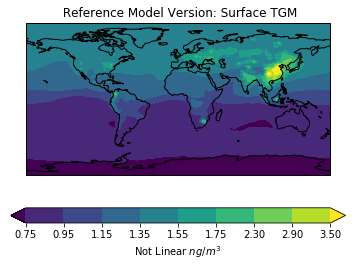

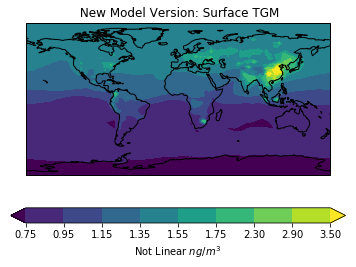

In [48]:
Levels= (0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50)




fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
im=TGM_Old.plot.contourf( x='lon',y='lat', ax=ax, levels= Levels, transform=ccrs.PlateCarree(), cmap='viridis', 
                         cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label':"Not Linear $ng/m^3$ "})

#ax.set_extent((0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50))
#Old.add_axes([0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50])
    
plt.title(' Reference Model Version: Surface TGM')             
ax.coastlines()
     
    

plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
im=TGM_New.plot.contourf(x='lon',y='lat',levels=Levels, ax=ax,transform=ccrs.PlateCarree(), cmap='viridis', 
                         cbar_kwargs={'orientation':'horizontal',
                                      'ticklocation':'auto',
                                      'label':"Not Linear $ng/m^3$ "})
#ax.set_extent((0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50))
#Old.add_axes([0.75, 0.95, 1.15, 1.35, 1.55, 1.75, 2.30, 2.90, 3.50])
    
plt.title(' New Model Version: Surface TGM')             
ax.coastlines()
plt.show()  
    


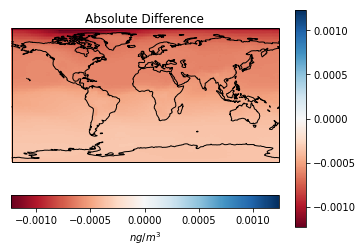

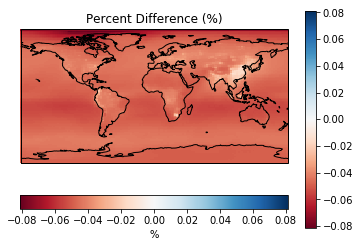

In [44]:
#Abs_diff = TGM_New - TGM_Old
#Perc_diff = (Abs_diff / TGM_Old)*100
Abs_max= np.max(np.abs(Abs_diff))
Per_max= np.max(np.abs(Perc_diff))


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
im= Abs_diff.plot.imshow(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap='RdBu', 
                         vmin=(-Abs_max), vmax=(Abs_max))
cb=plt.colorbar(im, orientation='horizontal', ticklocation='auto')
   # norm=colors.Normalize(vmin=(-Abs_max), vmax=Abs_max))
cb.set_label('$ng/m^3$',size=10)
#cb.set_clim((-Abs_max), (Abs_max))
plt.title("Absolute Difference")

#cb = fig.colorbar(im, ax=ax, orientation='v')


ax.coastlines()
plt.show()





fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
im= Perc_diff.plot.imshow(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap='RdBu',
                         vmin=(-Per_max), vmax=(Per_max))
plt.title("Percent Difference (%)")
cb=plt.colorbar(im, orientation='horizontal', ticklocation='auto')
cb.set_label('%',size=10)
ax.coastlines()
plt.show()
